## CONCLUSION

I had a lot of fun carefully analyzing and considering every decision I made in regards to this project.  For example, I use MSE loss by default.  I had never sat down and thought about what the specific effects of the loss function would be.  And I've never really played around with the different architectures and methodologies of approaching a problem.  If the result looked good enough (and I never did the due diligence to correctly evaluate what "good enough" would mean) then I kept it.  Unfortunately, despite all the time that I spent planning and researching did not save me from having a significantly flawed end result.  I'll cover the work that I did over a weekend a little later, but here is an example comparison of the predictions of my first (cropper) and second (GNet) attempt:

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/NetComparison6.PNG?raw=true)

Clearly, the second model is much more capable of creating portrait segmentation, even if it's not perfect.  So what exactly did I do throughout this project that ended up creating a poorly performing neural network?  What did I do to significantly increase performance on the challenge dataset?

## MY MISTAKES

I made a lot of mistakes while working on this project.  Some of these I caught and corrected during the process, and there were a few that I discovered towards the end.  The end result of my TNet and MNet were significantly worse on the celebrity dataset, so I quickly corrected errors and retrained a new network over a weekend.  Here is the list of the big errors that I believe I've made.

1. <b>Duplicates</b>.  I had looked through the dataset and did not find repeated people.  However, after doing another glance, I found that there were definitely repeats.  Not sure exactly how many but this could have impacted the way that the 'test' set evaluated the model.  I had initially ignored the given train/test split provided by the authors of the paper as I wanted to create my own.  However, that was shortsighted and I generated a new dataset using their provided split.  It's hard to tell exactly how impactful the occasional duplication was but I fixed the issue for the second model.
2. <b>Cropping in Backgrounds</b>.  I have a strong feeling that cropping out the images from their backgrounds and giving new backgrounds ended up being counter productive.  Jagged edges caused by imperfect ground truch mapping alongside drastic shifts in brightness between the background image and the person made it much easier to learn on the training set.  However, this is not true of real images and I believe this caused a lot of issues.  Even for images of people who did not show up in the training set (I checked manually), the results were really good.  However, due to the big drop off in quality towards the challenge dataset, I think it's clear that the new backgrounds made it easier, not harder, to handle.
3. <b>Noniterable Dataloader</b>.  Another issue was that I generated image augmentation during dataset creation, outside of the dataloader.  Even though each image was turned into 15 images, they were the same 15 images regardless of epoch.  This is a somewhat minor detail, but I made adjustments to the ImageDataset class object that performed the rotation and cropping of the image with each iteration. Therefore, each epoch of the original is equal to ~15 epochs of the new dataset.  However, I was able to train for 400 epochs for the new model and only ran for 10 epochs on the old.
4. <b>Image Sizes</b>.  Another big issue has to do with the size of the image.  Both models perform better when given an image the same dimensions as the data they were trained on.  In theory, I could have randomly resized the training data in order to compensate for this weakness, but this did not occur to me until I started writing this report and comparing the two models.  Regardless, another big impact that size had was the capacity of the GPU.  I had to make cuts to the neural networks and only run on a batch size of 1 in order to be able to fit the 600X800 images.  However, when I converted all images to 100X100 I was not only able to maintain the integrity of the UNet structure and run batches of 16, but I was able to train both the TNet and MNet together.  I named this new network the GluNet (GNet).  This is a much better strategy as it allows for both networks to learn from each other and work together.


Overall, the biggest lesson I've learned is to start simple.  Build something standard and see how well it works.  Then it's possible to troubleshoot where issues with data are coming from and what could be done to fix it.  I spent way too much time working on randomly adding backgrounds when a simpler approach blew that approach out of the water.

## SECOND ATTEMPT

This will look very familiar, so I'll just spend some time here reviewing the differences.  I changed the folder names where the images are stored so that I wouldn't overwrite the data I had already generated.  I also removed all forms of data augmentation in the data generation step, so that all I'm doing is saving the image, the matte, and generating the trimaps.  Because I'm shrinking each image to 100x100, the thickness of the trimap was much more important.  I started off using 2, then I changed that to 1 because both looked too thick.  Thickness of 1 looked way too thin, so I decided to experiment with both.

I was able to set the neural network (GluNet) to have both TNet and MNet together in one architecture.  This allowed for a much more cohesive training experience where the two networks learned together instead of one on top of the other.  I chose to train with the compositional loss as it worked the best from before.  I went with 400 epochs as the dataset was 15 times smaller (plus I'm training two networks so I figured I'd give it extra time to train).  As it turns out this was unecessary but I don't regret testing it out.

Finally, the ImageDataset class was given all of the image augmentations that I used before.  This means that each image gets 400 unique versions of itself, instead of the max being 20 from before.

In [1]:
# Importing the required libraries

import os
from os import path
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from scipy.io import loadmat
from skimage import io
import imutils
from tqdm import tqdm
import random

from PIL import Image,ImageOps


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from Backend import UNet, GluNet, Cropper



CURRENT_DIR = path.abspath(path.curdir)
FOLDER = '/[EG_code_data]_release/data/'
IMG_SIZE = (100,100)

urls = pd.read_csv(CURRENT_DIR + FOLDER + 'alldata_urls.txt',names=['name','url'],delimiter=' ')
crops = pd.read_csv(CURRENT_DIR + FOLDER + 'crop.txt',names=['name','leftx','lefty','rightx','righty'],delimiter=' ')
trainlist = list(loadmat(CURRENT_DIR + FOLDER + 'trainlist')["trainlist"][0])
testlist = list(loadmat(CURRENT_DIR + FOLDER + 'testlist')["testlist"][0])

img_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.75)
    ,transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
for sample in tqdm(urls.T.iteritems()):
    
    try:
        og = io.imread(sample[1][1])
        crop = crops[crops['name']==sample[1][0]]
        og = og[crop['leftx'].values[0]:crop['lefty'].values[0],crop['rightx'].values[0]:crop['righty'].values[0],:]
        og = cv2.resize(og,IMG_SIZE)
        og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
        
        if int(sample[1][0].split('.')[0]) in testlist:
            traintest = 'test'

        elif int(sample[1][0].split('.')[0]) in trainlist:
            traintest = 'train'
            
        else:
            traintest = 'neither'
        
 
        

        # Grabbing the image and mask from the dataset
        image = og.copy()
        mask = np.asarray(loadmat(CURRENT_DIR + FOLDER + '/images_mask/' + sample[1][0].split('.')[0] + '_mask.mat')['mask'])
        mask = cv2.resize(mask,IMG_SIZE)
        

        inv_mask = cv2.bitwise_not(mask) - 254

        data = image.copy()

        # Saving the results to a file
        
        ret, thresh = cv2.threshold(mask,127,255,0)
        contours,hierarchy = cv2.findContours(mask, 1, 2)
        trimap = cv2.drawContours(np.zeros((IMG_SIZE[1],IMG_SIZE[0])), contours, -1,(255),thickness=-1)

        trimap = cv2.drawContours(trimap,contours,-1,(127),thickness=2)
        kernel = np.ones((5,5),np.uint8)
        trimap = cv2.erode(trimap,kernel,iterations=3)
        trimap = cv2.dilate(trimap,kernel,iterations=3)
        

        
        background_channel = np.where(trimap==0,float(1),0)
        uncertain_channel = np.where(trimap==127,float(1),0)
        foreground_channel = np.where(trimap==255,float(1),0)
        trimap = cv2.merge((background_channel,uncertain_channel,foreground_channel))

        cv2.imwrite(os.path.join(CURRENT_DIR,'data2',traintest,'data_' + sample[1][0].split('.')[0] + '.png'),data)
        cv2.imwrite(os.path.join(CURRENT_DIR,'matte2',traintest,'matte_' + sample[1][0].split('.')[0] + '.png'),mask)
        cv2.imwrite(os.path.join(CURRENT_DIR,'trimap2',traintest,'trimap_' + sample[1][0].split('.')[0] + '.png'),trimap)


    except Exception as e:

#         print(e)
        pass

    

print(len(os.listdir(CURRENT_DIR + '/data2/train/')) + len(os.listdir(CURRENT_DIR + '/data2/test/'))) 

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat((x1,x2),1)
        x = self.conv(x)
        return x
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class GluNet(nn.Module):
    def __init__(self, bilinear=True):
        super(GluNet, self).__init__()
        self.bilinear = bilinear

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256,64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64,3)
        
        self.inc1 = DoubleConv(6, 64)
        self.down1_1 = Down(64, 128)
        self.down2_1 = Down(128, 256)
        self.down3_1 = Down(256,512)
        self.down4_1 = Down(512,512)
        self.up1_1 = Up(1024, 256, bilinear)
        self.up2_1 = Up(512, 128, bilinear)
        self.up3_1 = Up(256,64, bilinear)
        self.up4_1 = Up(128, 64, bilinear)
        self.outc1 = OutConv(64,1)
        


    def forward(self, image):
        
        
        
        x1 = self.inc(image)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x4,x5)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        
        trimap = F.softmax(self.outc(x),dim=1)
        x = torch.cat((image,trimap),1)


        x1 = self.inc1(x)
        x2 = self.down1_1(x1)
        x3 = self.down2_1(x2)
        x4 = self.down3_1(x3)
        x5 = self.down4_1(x4)
        x = self.up1_1(x4,x5)
        x = self.up2_1(x,x3)
        x = self.up3_1(x,x2)
        x = self.up4_1(x,x1)

        matte = torch.sigmoid(self.outc1(x))

        return trimap, matte

In [ ]:
class ImageDataset(Dataset):

    def __init__(self,test=False,transform=None):
        self.root = path.abspath(path.curdir)
        self.transform = transform
        self.traintest = 'test' if test else 'train'
        self.data = os.listdir(self.root + f'/data2/{self.traintest}/')
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):

        if torch.is_tensor(index):
            index = index.tolist()

        item = Image.open(self.root + f'/data2/{self.traintest}/' + self.data[index])
        trimap = Image.open(self.root + f'/trimap2/{self.traintest}/' + self.data[index].replace("data","trimap"))
        matte = Image.open(self.root + f'/matte2/{self.traintest}/' + self.data[index].replace("data","matte"))
        
        
        flip = np.random.randint(0,2)
        
        if flip>0:
            
            item = ImageOps.mirror(item)
            trimap = ImageOps.mirror(trimap)
            matte = ImageOps.mirror(matte)
        
        rotation = np.random.randint(-30,31)
        item = item.rotate(rotation)
        trimap = trimap.rotate(rotation)
        matte = matte.rotate(rotation)
        
        x1, y1, x2, y2 = np.random.randint(0,26), np.random.randint(0,26), 100 - np.random.randint(0,26), 100-np.random.randint(0,26)
        
        item = item.crop((x1,y1,x2,y2))
        trimap = trimap.crop((x1,y1,x2,y2))
        matte = matte.crop((x1,y1,x2,y2))
        
        item = item.resize((100,100))
        trimap = trimap.resize((100,100))
        matte = matte.resize((100,100))
        
        
        if self.transform:
            item = self.transform(item)
            trimap = transforms.ToTensor()(trimap)*255
            matte = transforms.ToTensor()(matte)*255

        
        return item, trimap, matte

In [ ]:
trainset = ImageDataset(transform=img_transform)

trainloader = DataLoader(
    trainset,
    batch_size=16,
    shuffle=True
    )

In [ ]:
class CompositionalLoss(nn.Module):
    
    
    def __init__(self) -> None:
        super(CompositionalLoss, self).__init__()
        self.epsilon: float = 1e-6
        
    def forward(self,output,target):
        
       
        loss = torch.pow(torch.pow(output - target,2) + self.epsilon,0.5)
        
        return torch.mean(loss)

In [ ]:
EPOCHS = 400
LR = 0.001
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CURRENT_DIR = path.abspath(path.curdir)

GNet = GluNet()
GNet.to(DEVICE)
optimizer = optim.Adam(GNet.parameters(),lr=LR)
loss_function1 = CompositionalLoss()
loss_function2 = CompositionalLoss()

In [ ]:
def train(net,trainloader):
    
    loss_tracker = []
    
    for epoch in range(EPOCHS):
        
        avg_loss = 0
        
        for data in tqdm(trainloader): 
            
            net.zero_grad()
            
            images, trimaps, mattes = data[0].float().to(DEVICE), data[1].float().to(DEVICE), data[2].float().to(DEVICE)


            outputs1, outputs2 = net(images)
            loss = loss_function1(outputs1,trimaps) + loss_function2(outputs2,mattes)
            loss.backward()
            optimizer.step()
            
            images.cpu()
            trimaps.cpu()
            mattes.cpu()

            avg_loss += loss
            
        avg_loss /= 20592    

        print(f"Epoch: {epoch+1}. Avg Loss: {avg_loss}.")
        
        loss_tracker.append(avg_loss)
        
        torch.save(GNet.state_dict(),CURRENT_DIR + f'/Models/GNET COMP v{epoch+1}')
        
    return loss_tracker

In [2]:
CURRENT_DIR = path.abspath(path.curdir)
CELEB_DIR = CURRENT_DIR + '/Celeb Data/img_align_celeba/'
CHALLENGE_DATA = os.listdir(CELEB_DIR)
TRANSFORM = transforms.Compose([transforms.ColorJitter(brightness=0.75),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
cropper = Cropper() # Model attempt #1
GNet = GluNet() # Model attempt #2

## GNET EPOCHS

I'm well aware of the danger of overfitting, however I'm not so confident I understand it at a practical level.  What's imporant to keep in mind is that the dataset being trained is 15 times smaller than the one used to train my first attempt.  Even though it is smaller, I keep the augmentations iterable, so overfitting is slightly less likely since the augmentations aren't static between epochs.  Another thing to note is that the loss is now calculated by summing the trimap and mattes losses as both parts of the neural network are being trained together.  Here is the graph of the losses throughout the 400 epochs of gnet training.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/Losses.PNG?raw=true)

I believe that the optimal epoch to pull from is in the 200-300 range.  I'm going to test this by evaluating the results based on epoch for the challenge data.  I've written a function that will randomly pull examples from the data, but is also capable of taking the name of a file as an input.  It then compares the results of the model in intervals of 50 epochs.

In [4]:
def compare_epochs(GNet,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image).resize((100,100))
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA)).resize((100,100))
    
    f, axarr = plt.subplots(2,9,figsize=(15,15),sharex=True)
    axarr[0,0].set_title('Original Image')
    axarr[1,0].set_title('Original Image')
    [axi.set_axis_off() for axi in axarr.ravel()]
    axarr[0,0].imshow(np.asarray(sample))
    axarr[1,0].imshow(np.asarray(sample))
    
    for i in range(8):
            
            GNet.load_state_dict(torch.load(CURRENT_DIR + f'/Models/Versions/COMP/GNET COMP v{(i+1)*50}'))
            
            with torch.no_grad():
                trimap, matte = GNet(TRANSFORM(sample).unsqueeze(0))
 
            axarr[0,i+1].set_title(f'Epoch {(i+1)*50}')
            axarr[1,i+1].set_title(f'Epoch {(i+1)*50}')
            axarr[0,i+1].imshow(trimap.squeeze().numpy().transpose(1,2,0))
            axarr[1,i+1].imshow(matte.squeeze().numpy(),cmap="gray")
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

This is a perfect example of what I was worried about in the beginning of the project.  There are quite a few examples of distortions near the top of the image.  It looks like hair and extends out of the head but in reality it is just an unfortunate distortion.  By epoch 150, the model has learned to ignore these kinds of situations, which is very impressive.

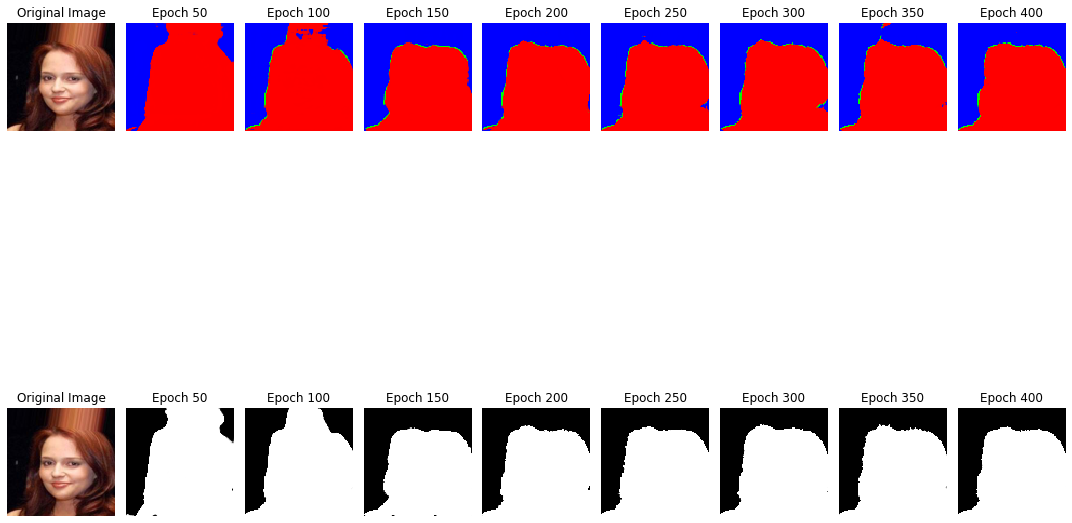

In [13]:
compare_epochs(GNet)

This is another example where the model has effectively learned by epoch 150.  The important thing to note from this example is that the predicted trimap is significantly nosier than the matte prediction.  It seems to be doing what was intended by identifying uncertain regions.  The matte has become much better at looking at the trimap predictions and has learned what to ignore.  Any noisy uncertainty, such as the tie or the background at the top left, gets correctly categorized by the alpha matte.  Another interesting feature is that the model seems to regress when it hits epoch 400, having a big mass at the right side of the person's face.

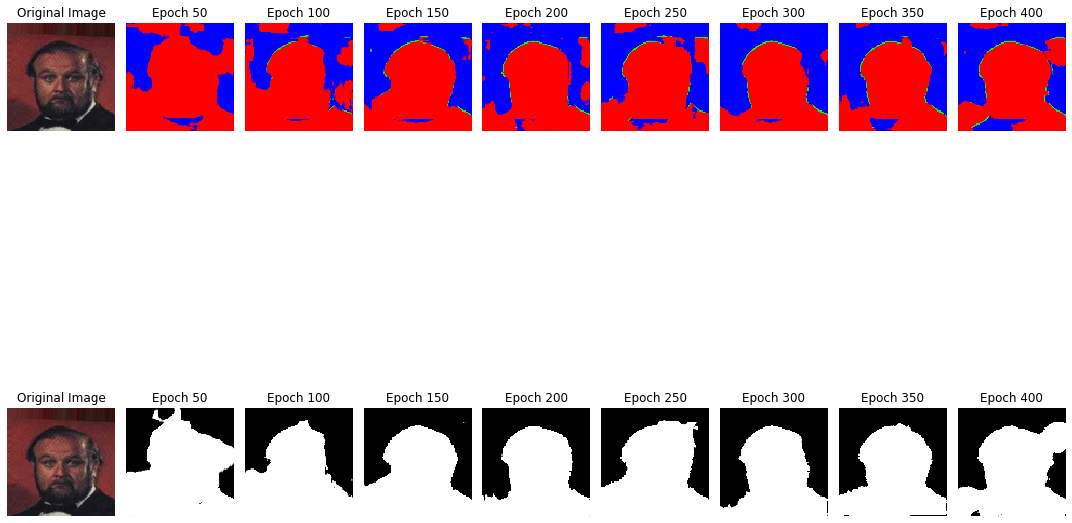

In [15]:
compare_epochs(GNet)

The next two images help to demonstrate that epoch 150 seems to have the best consistency in ignoring the initial mistakes but also not overfitting.

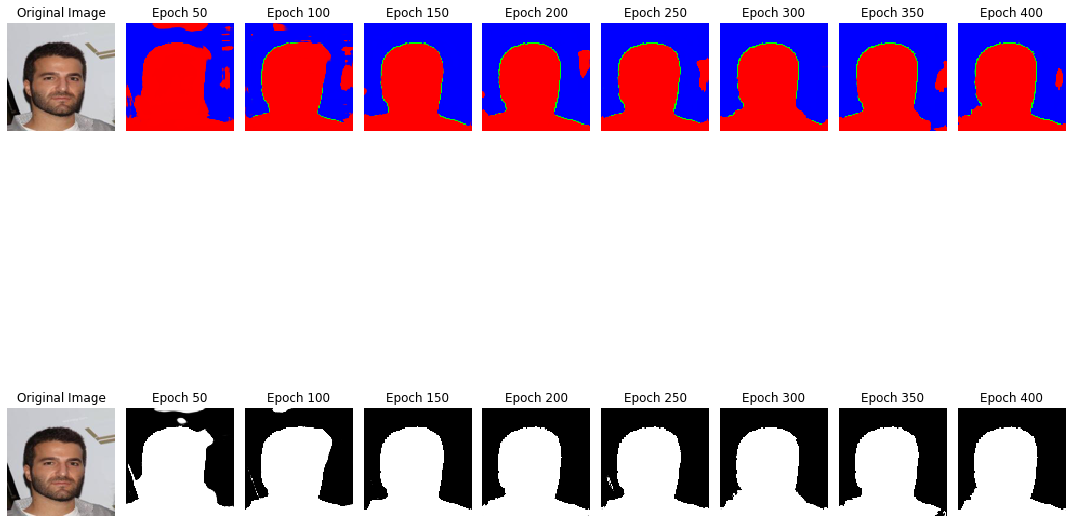

In [19]:
compare_epochs(GNet)

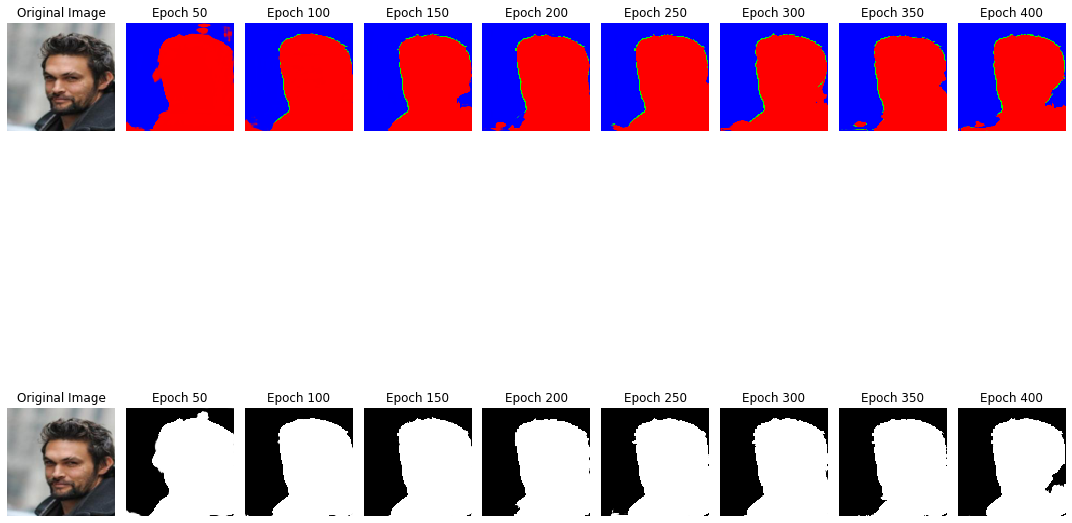

In [16]:
compare_epochs(GNet)

## UNCERTAINTY TRIMAP COMPARISON

I was not expecting this at all, but I'll be sticking with epoch 150 when it comes to comparing the different models.  Admittedly, I'm still very inexperienced and don't know if there's a better method to determining the quality or where an epoch should be chosen. However, no matter the small tweaks I had made before training, epoch 150 seemed to be where the peak performance lands.  From what I read online, it seems like looking at loss over time as well as performance on the challenge data set should be sufficient.  If the performance of the model stops to improve, then the earliest point where this happens should be the chosen model in an attempt to minimize overfitting.

So, I wrote this code in order to compare the two different Gnet models (GNet1 had a dataset with a trimap countour thickness of 1 while GNet2 had a thickness of 2).  Don't worry if that doesn't make sense, the differences are very clear when we get to the predicted trimap.  Essentially, what this does is prove that the trimap performs a very important role.  The uncertainty region for GNet1 is so small that it may as well be trying to predict the alpha matte twice.  As it turns out, GNet2 does a much better job of understanding the overal shape of the person through the uncertainty region and is able to fit to the person much better in the alpha matte.  Therefore, I decided to go with the model trained on the thicker uncertainty region.

Below is the code that I wrote to compare the effects caused by the thickness of the uncertainty region alongside three examples of the two different models trained.

In [ ]:
def compare_models_thickness(gnet1,gnet2,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image)
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA))



    with torch.no_grad():
        trimap1, matte1 = gnet1(TRANSFORM(sample.resize((100,100))).unsqueeze(0))
        trimap2, matte2 = gnet2(TRANSFORM(sample.resize((100,100))).unsqueeze(0))

    f, axarr = plt.subplots(2,3,figsize=(5,5))

    axarr[0,0].set_title("Input Image")
    axarr[0,1].set_title("GluNet1 Prediction")
    axarr[0,2].set_title("GluNet2 Prediction")
    [axi.set_axis_off() for axi in axarr.ravel()]

    axarr[0,0].imshow(np.asarray(sample))
    axarr[0,1].imshow(trimap1.squeeze().numpy().transpose(1,2,0))
    axarr[1,1].imshow(matte1.squeeze().numpy(),cmap="gray")
    axarr[0,2].imshow(trimap2.squeeze().numpy().transpose(1,2,0))
    axarr[1,2].imshow(matte2.squeeze().numpy(),cmap="gray")

    plt.tight_layout();

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/ThicknessComparison1.PNG?raw=true)

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/ThicknessComparison2.PNG?raw=true)

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/ThicknessComparison3.PNG?raw=true)

## MODEL COMPARISON

So, now I get to go over and compare my first and second attempt at this challenge.  I've gone over extensively the differences between the two models, so I'll just clarify that Cropper is my first attempt and GNet is my second.  Below is the code that I wrote in order to compare the two different models and their performance on the challenge data.

In [5]:
def compare_models(GNet,cropper,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image)
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA))


    matte, _ = cropper(sample)

    with torch.no_grad():
        trimap = cropper.TNet(TRANSFORM(sample.resize(((600,800)))).unsqueeze(0))
        G_trimap, G_matte = GNet(TRANSFORM(sample.resize((100,100))).unsqueeze(0))

    f, axarr = plt.subplots(2,3,figsize=(5,5))

    axarr[0,0].set_title("Input Image")
    axarr[0,1].set_title("Cropper Prediction")
    axarr[0,2].set_title("GluNet Prediction")
    [axi.set_axis_off() for axi in axarr.ravel()]

    axarr[0,0].imshow(np.asarray(sample))
    axarr[0,1].imshow(cv2.resize(trimap.squeeze().numpy().transpose(1,2,0),(100,100)))
    axarr[1,1].imshow(cv2.resize(matte,(100,100)),cmap="gray")
    axarr[0,2].imshow(G_trimap.squeeze().numpy().transpose(1,2,0))
    axarr[1,2].imshow(G_matte.squeeze().numpy(),cmap="gray")

    plt.tight_layout();

In [6]:
GNet = GluNet()
GNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/GNET COMP v150'));

When it comes to the hair distortion, GluNet blows my previous nn out of the water.  The top of the head in the predicted matte does not look normal at all, but the model is able to correctly understand that this was a distortion in the image.

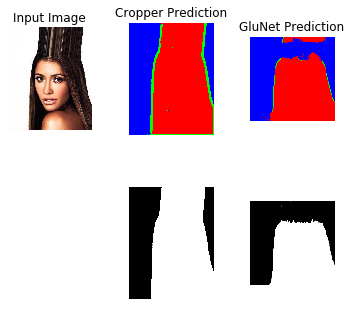

In [29]:
compare_models(GNet,cropper)

Here, cropper fails to understand that the hair is a part of the person, while GNet is able to get the relative shape of her head.

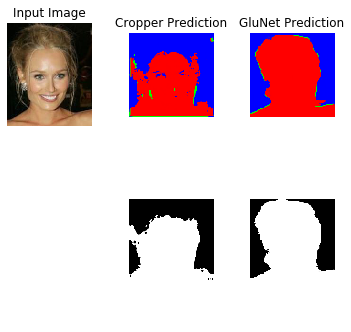

In [38]:
compare_models(GNet,cropper)

## TESTING LIMITS

Ok, I've gone over the challenge dataset and compared my two attempts at portrait segmentation.  As we've seen, GNet does a much better job of creating a more cohesive picture and contextualizing hair.  Now I'd like to take some fringe cases that I mentioned in the very beginning of this project and analyze how they'd perform.  I would like to know how the two models perform when:

1. There are two people in the photo

2. The picture is a full body shot

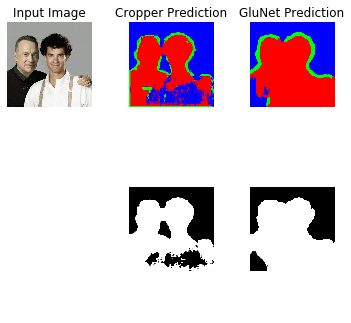

In [7]:
compare_models(GNet,cropper,'Hanks.jpg')

Oddly enough, while there is a gaping hole where young Tom Hanks chest should be, Cropper does a much better job of understanding that the image is of two people.  GNet seems to be struggling to create a single person out of the image using global context values, but Cropper seems to be able to handle things at a more detailed level.  This approach, however, leads it to make massive mistakes on pictures, even if there is only one person in the shot.

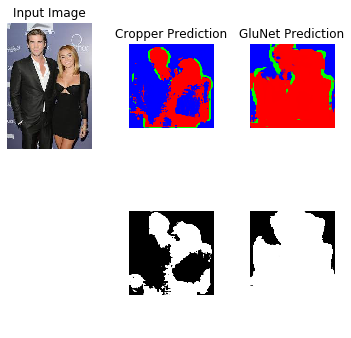

In [9]:
compare_models(GNet,cropper,'Couple.jpg')

Yet again, Cropper is absolutely terrible, but it still does a better job of understanding that there are two people in the image.

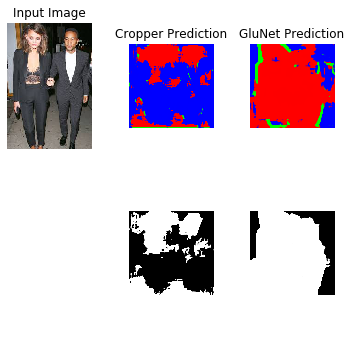

In [10]:
compare_models(GNet,cropper,'Couple2.jpg')

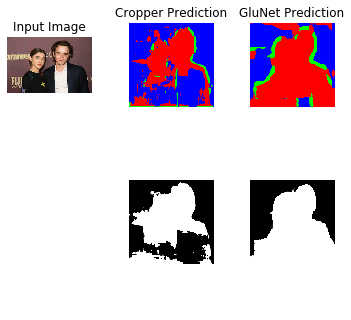

In [11]:
compare_models(GNet,cropper,'Couple3.jpg')

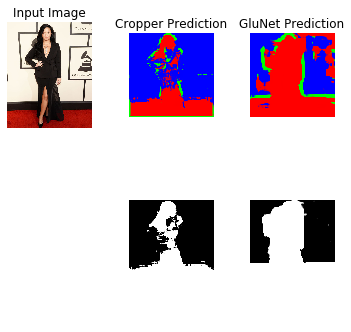

In [15]:
compare_models(GNet,cropper,'FullBody.jpg')

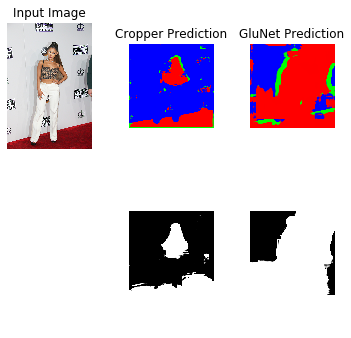

In [16]:
compare_models(GNet,cropper,'FullBody2.png')

## FINAL CONCLUSION

Perfect portrait segmention is very difficult.  There are way too many egde cases and backgrounds that it is impossible for a neural network to perfectly detect and predict the foreground.  When there is more than one person in the picture, cropper completely falls apart while GluNet tries to glue the two people together into one.  When the full body is in the shot, both networks try to reconcile this by making the floor the shoulders and the body the head, even if GluNet is much better at it.  These two cases serve to prove a point because they are nowhere near edge cases from a human perspective.  As I suspected, the networks learned the general shape of a person's portrait (shoulders up) and does it's best to reconcile the image it's given with that.  It doesn't care if a person is actually there or if there's more to that person.  

In fact, it is very important to be able to understand exactly what the neural network has learned.  Computer vision is a fascinating field, but there are very clear limitations.  In addition to their 'thought' process being practically unexplainable once trained, convolutional neural networks can be overly sensitive to texture/color in classification tasks.  While the portrait segmentations might look decent and would look much better with more data / bigger network, it is necessary to understand that the actual result is still quite niche.

So, what are the current limitations that impede progress on this kind of computer vision task?

1. <b>Data</b>.  This is a very meme answer, but with methods like YOLO, we've seen that we have the ability to do complicated semantic segmentation tasks.  Not only that, but we can differentiate between different instances of the same class (multiple cats).  Unfortunately, we don't have a dataset available that has multiple instances of people or full body pictures.  No one will want an AI that can crop them out of a picture but won't work at all with a selfie of them and a loved one.  It doesn't matter how powerful of a neural network architecture we can construct if it can't handle different scenarios other than an above shoulders shot of a single person.
2. <b>Fashion</b>.  Our style in fashion is unpredictable.  Colors can be dull or vibrant, and so can the background people find themselves in.  Hats and hair are the worst, as well as handbags on the side or clothes with distinct color boundaries.  The neural networks seems to be able to handle patterns well, but draw strings on a top or the line between the suit and the suit jacket near the tie seem to cause issues.  It makes it much harder to the nnet to distinguish where the clothes end and where to start ignoring the background.  This will only get much worse when full body pictures are included.
3. <b>Computational Power</b>.  I may be very wrong about this because we may find a much better solutionarchitecture down the line, but we are significantly limited by computational power at the moment.  From my understanding, the main reason we use maxpooling is because we would not be able to handle the amount of weights and computing power that a CNN would normally require.  This may sound obvious right now as well as insurmountable, but a large reason why neural networks in general have sprung up have been because of the increase in computing power and explosion in data.  In fact, neural networks (multi-layer perception) were used in the 1980s but disregarded because it cost too much to tune.  The discovery of backpropogation is what really set up deep learning for its success.  I put this last because even though it is naive to assume that we will never be able avoid maxpooling layers, there are no actionable steps at the moment in order to fix the issue. 


Overall, I'm very happy with my ability to troubleshoot and improve upon my mistakes.  I'm also fairly disappointed with the final results as the problem I was solving was very niche and limited.  I'm confident that my next project will be a lot better due to this experience of analyzing everything and performing thorough research.  I've included a few more comparisons below just to help illustrate the point that I was able to improve my initial model, even if the results aren't perfect.

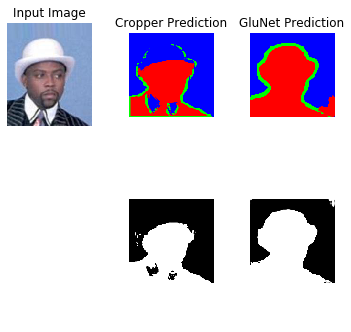

In [19]:
compare_models(GNet,cropper,'000731.jpg')

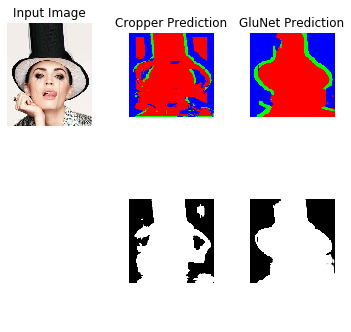

In [15]:
compare_models(GNet,cropper,'000074.jpg')

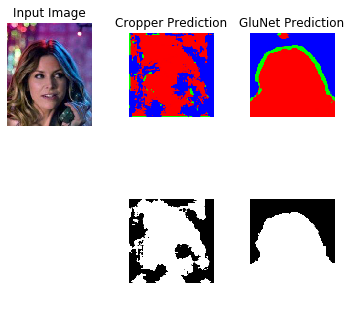

In [7]:
compare_models(GNet,cropper)

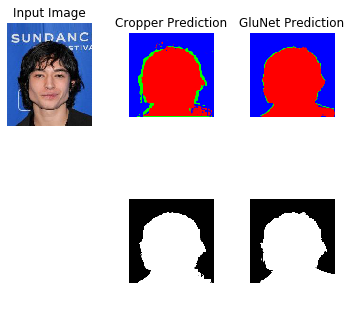

In [39]:
compare_models(GNet,cropper)

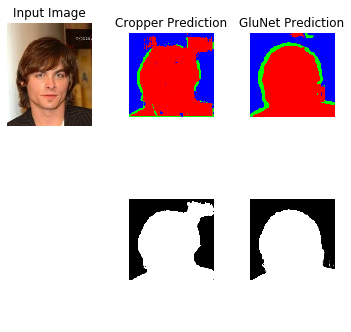

In [8]:
compare_models(GNet,cropper)

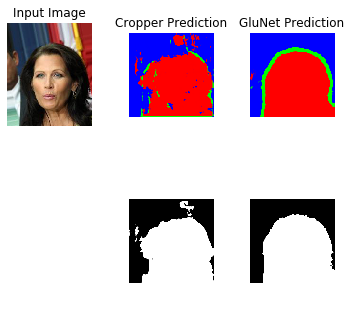

In [10]:
compare_models(GNet,cropper)

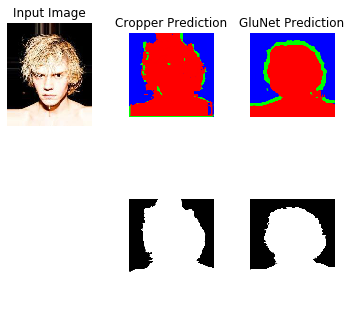

In [11]:
compare_models(GNet,cropper)

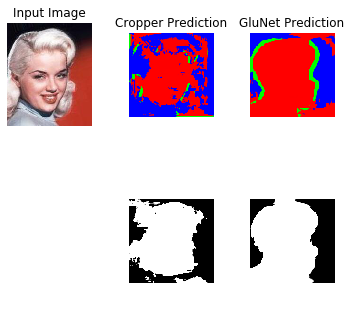

In [12]:
compare_models(GNet,cropper)

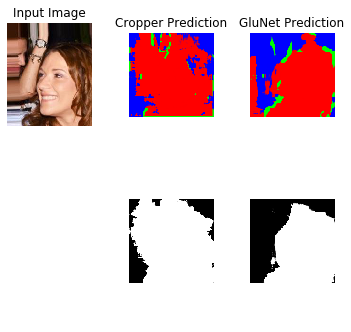

In [18]:
compare_models(GNet,cropper,'000725.jpg')

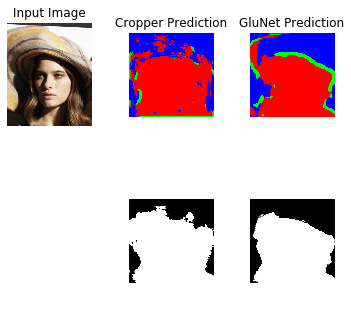

In [21]:
compare_models(GNet,cropper,'000862.jpg')